# 图像增广



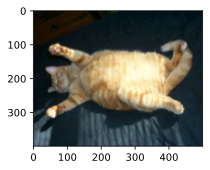

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

左右翻转图像

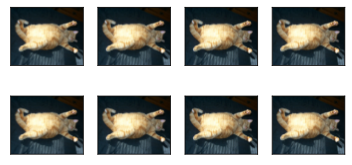

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

上下翻转图像

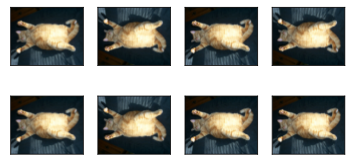

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

随机裁剪

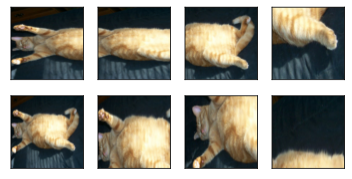

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

随机更改图像的亮度

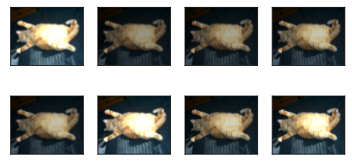

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

随机更改图像的色调

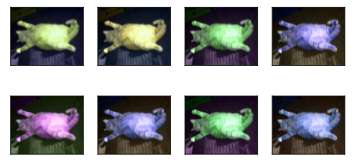

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

随机更改图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）

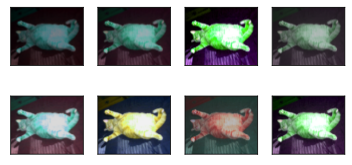

In [9]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

结合多种图像增广方法

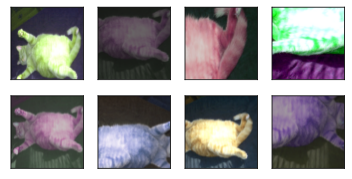

In [10]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

使用图像增广进行训练

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

只使用最简单的随机左右翻转

In [12]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

定义一个辅助函数，以便于读取图像和应用图像增广

In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

定义一个函数，使用多GPU对模型进行训练和评估

In [15]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

定义`train_with_data_aug`函数，使用图像增广来训练模型

In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

训练模型

loss 0.167, train acc 0.942, test acc 0.824
4751.8 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


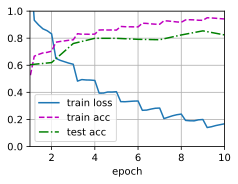

In [17]:
train_with_data_aug(train_augs, test_augs, net)